In [23]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import json
import time
import re
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', None)

In [2]:
# Load JSON data (replace 'data.json' with the actual file path)
with open("trials.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

In [3]:
df = pd.DataFrame([{
    "RCT_ID": item.get("RCT ID", None),
    "Title": item.get("Title", None),
    "Status": item.get("Status", None),
    "Start_Date": item.get("Start date", None),
    "End_Date": item.get("End date", None),
    "Country": ", ".join([c["Country"] if isinstance(c, dict) else str(c) for c in item.get("Countries", [])]) if "Countries" in item else None,
    "Region": ", ".join([c["Region"] if isinstance(c, dict) and isinstance(c["Region"], str) else str(c["Region"]) if isinstance(c["Region"], list) else "" for c in item.get("Countries", [])]) if "Countries" in item else None,
    "PI_Name": item.get("Primary PI", {}).get("Name", None),
    "PI_Affiliation": item.get("Primary PI", {}).get("Affiliation", None),
    "Keywords": ", ".join(item.get("Keywords", [])) if item.get("Keywords") else None,
    "Additional_Keywords": ", ".join(item.get("Additional Keywords", [])) if item.get("Additional Keywords") else None,
    "JEL_Codes": ", ".join(item.get("JEL code(s)", [])) if item.get("JEL code(s)") else None,
    "Secondary_IDs": ", ".join(item.get("Secondary IDs", [])) if item.get("Secondary IDs") else None,
    "Abstract": item.get("Abstract", None),
    "External_Links": ", ".join(item.get("External Link(s)", {}).get("Link", [])) if isinstance(item.get("External Link(s)"), dict) else None,
    "Citation": item.get("Citation", None),
    "Former_Citation": item.get("Former Citation", None),
    "Intervention": item.get("Intervention(s)", None),
    "Intervention_Hidden": item.get("Intervention (Hidden)", None),
    "Intervention_Start_Date": item.get("Intervention Start Date", None),
    "Intervention_End_Date": item.get("Intervention End Date", None),
    "Primary_Outcomes": ", ".join(item.get("Primary Outcomes (end points)", [])) if item.get("Primary Outcomes (end points)") else None,
    "Primary_Outcomes_Explanation": item.get("Primary Outcomes (explanation)", None),
    "Secondary_Outcomes": ", ".join(item.get("Secondary Outcomes (end points)", [])) if item.get("Secondary Outcomes (end points)") else None,
    "Secondary_Outcomes_Explanation": item.get("Secondary Outcomes (explanation)", None),
    "Experimental_Design": item.get("Experimental Design", None),
    "Experimental_Design_Details": item.get("Experimental Design Details", None),
    "Randomization_Method": item.get("Randomization Method", None),
    "Randomization_Unit": item.get("Randomization Unit", None),
    "Treatment_Clustered": item.get("Was the treatment clustered?", None),
    "Planned_Clusters": item.get("Sample size: planned number of clusters", None),
    "Planned_Observations": item.get("Sample size: planned number of observations", None),
    "Sample_By_Treatment_Arms": item.get("Sample size (or number of clusters) by treatment arms", None),
    "Minimum_Detectable_Effect": item.get("Minimum detectable effect size for main outcomes (accounting for sampledesign and clustering)", None),
    "Intervention_Completed": item.get("Is the intervention completed?", None),
    "Data_Collection_Complete": item.get("Data Collection Complete", None),
    "Public_Data_Available": item.get("Is public data available?", None),
    "Program_Files": item.get("Program Files", None)
} for item in json_data.values()])

# Extract multiple investigators separately
df_pis = pd.concat([
    pd.DataFrame({
        "RCT_ID": item.get("RCT ID", None),
        "PI_Name": [pi.get("Name", None) for pi in item.get("Other Primary Investigators", [])],
        "PI_Affiliation": [pi.get("Affiliation", None) for pi in item.get("Other Primary Investigators", [])]
    }) for item in json_data.values() if "Other Primary Investigators" in item
], ignore_index=True)

# Extract IRB approvals separately
df_irbs = pd.concat([
    pd.DataFrame({
        "RCT_ID": item.get("RCT ID", None),
        "IRB_Name": [irb.get("Name", None) for irb in item.get("IRBs", [])],
        "IRB_Approval_Date": [irb.get("Approval Date", None) for irb in item.get("IRBs", [])],
        "IRB_Approval_Number": [irb.get("Approval Number", None) for irb in item.get("IRBs", [])]
    }) for item in json_data.values() if "IRBs" in item
], ignore_index=True)

In [4]:
df.columns

Index(['RCT_ID', 'Title', 'Status', 'Start_Date', 'End_Date', 'Country',
       'Region', 'PI_Name', 'PI_Affiliation', 'Keywords',
       'Additional_Keywords', 'JEL_Codes', 'Secondary_IDs', 'Abstract',
       'External_Links', 'Citation', 'Former_Citation', 'Intervention',
       'Intervention_Hidden', 'Intervention_Start_Date',
       'Intervention_End_Date', 'Primary_Outcomes',
       'Primary_Outcomes_Explanation', 'Secondary_Outcomes',
       'Secondary_Outcomes_Explanation', 'Experimental_Design',
       'Experimental_Design_Details', 'Randomization_Method',
       'Randomization_Unit', 'Treatment_Clustered', 'Planned_Clusters',
       'Planned_Observations', 'Sample_By_Treatment_Arms',
       'Minimum_Detectable_Effect', 'Intervention_Completed',
       'Data_Collection_Complete', 'Public_Data_Available', 'Program_Files'],
      dtype='object')

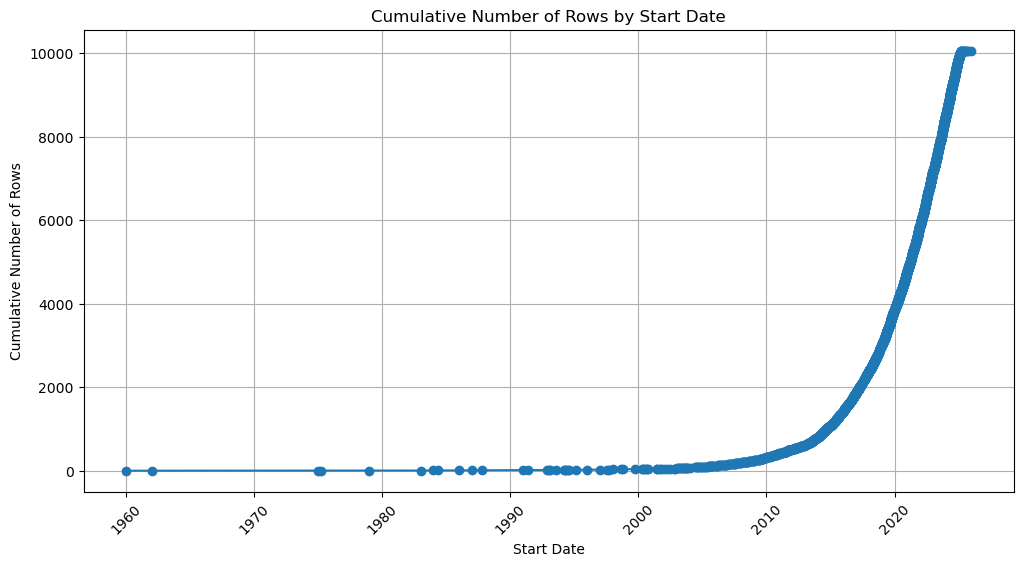

In [25]:
df["Start_Date"] = pd.to_datetime(df["Start_Date"], errors="coerce")

# Drop NaT values
df = df.dropna(subset=["Start_Date"])

# Compute cumulative count of rows over time
date_counts = df.groupby("Start_Date").size().cumsum()

# Plot cumulative sum
plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')

plt.xlabel("Start Date")
plt.ylabel("Cumulative Number of Rows")
plt.title("Cumulative Number of Rows by Start Date")
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

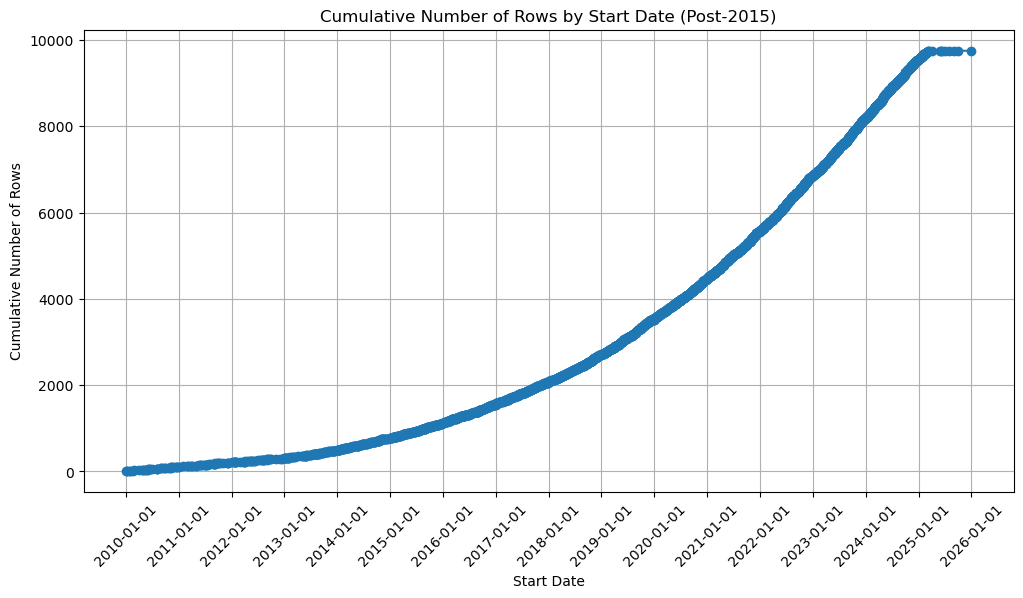

'cumulative_rows_by_start_date.png'

In [29]:
df_filtered = df[df["Start_Date"] >= "2010-01-01"]

# Compute cumulative count of rows over time
date_counts = df_filtered.groupby("Start_Date").size().cumsum()

# Plot cumulative sum with yearly labels
plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')

plt.xlabel("Start Date")
plt.ylabel("Cumulative Number of Rows")
plt.title("Cumulative Number of Rows by Start Date (Post-2015)")
plt.xticks(rotation=45)

# Set yearly x-axis ticks
plt.xticks(pd.date_range(start="2010-01-01", end=df_filtered["Start_Date"].max(), freq="YS").strftime("%Y"))

plt.grid(True)

# Save the plot
plot_filename = "cumulative_rows_by_start_date.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Confirm the file is saved
plot_filename

In [21]:
df['Country'].value_counts()[0:100]

Country
United States of America                                                          2014
Germany                                                                            711
India                                                                              531
China                                                                              350
United Kingdom of Great Britain and Northern Ireland                               281
Kenya                                                                              257
Uganda                                                                             197
Pakistan                                                                           194
Bangladesh                                                                         187
Italy                                                                              155
Colombia                                                                           142
Switzerland                        

In [20]:
df['Sample_By_Treatment_Arms'][:10]

0                                                  NaN
1                            24 clusters per study arm
2    98 school campuses control, 93 school campuses...
3               69 treatment blocks,127 control blocks
4    2821 individuals free DFS,  3224 individuals n...
5    14 or 15 villages in each info campaign.  387 ...
6     3000 households in treatment and 3000 in control
7    682 treatment students/households and 1382 con...
8      See the attached pre-analysis plan for details.
9    500 households treatment, 500 households spill...
Name: Sample_By_Treatment_Arms, dtype: object

In [7]:
df.to_csv("trials.csv", index = False)

In [14]:
# Load the dataset
DATA_FILE = "trials.csv"
df = pd.read_csv(DATA_FILE)

def extract_numeric_value(text):
    """Extracts a numeric value from text, handling cases like '35 million', '28 thousand', '5,756 households',
    '2.7 million', and '1.3M students'. Ensures that the multiplier (if any) is the word or abbreviation 
    immediately following the number. Limits processing to text with 3 words or fewer."""
    text = text.strip().lower().replace(",", "")  # Remove commas and extra spaces
    words = text.split()
    
    if len(words) > 4:
        return None  # Only process if there are 3 or fewer words
    
    number_map = {
        "million": 1_000_000,
        "thousand": 1_000,
        "billion": 1_000_000_000,
        "hundred": 100,
        "m": 1_000_000,  # Handling abbreviations like '1.3M'
        "k": 1_000
    }
    
    matches = re.findall(r'(\d+(?:\.\d+)?)\s*(\w+)?', text)  # Extract numbers, including decimals, and the next word
    
    if not matches:
        return None
    
    num = float(matches[0][0])  # Extract first number as float for decimal handling
    next_word = matches[0][1] if len(matches[0]) > 1 else ""
    
    if next_word in number_map:
        return int(num * number_map[next_word])  # Convert to integer after applying multiplier
    
    return int(num) if num < 1_000_000_000 else None  # Ignore extreme values

# Pre-fill sample_size where possible
def auto_fill_sample_sizes():
    global df
    df.loc[df["sample_size"].isna(), "sample_size"] = df["Planned_Observations"].apply(lambda x: extract_numeric_value(str(x)))
    df.to_csv(DATA_FILE, index=False)
    print("✅ Auto-filled sample sizes where applicable.")

def process_data():
    global df  # Ensure we're modifying the global dataframe
    
    if "sample_size" not in df.columns:
        df["sample_size"] = None  # Initialize column
    
    auto_fill_sample_sizes()  # Apply auto-fill before manual entry
    
    row_idx = 0  # Track the current index dynamically
    
    while row_idx < len(df):  # Loop through all rows
        df_uncoded = df[df["sample_size"].isna()].copy()  # Refresh uncoded rows
        
        if df_uncoded.empty:
            print("No uncoded rows left!")
            break

        # Select the first uncoded row dynamically
        row = df_uncoded.iloc[0]
        planned_obs = str(row["Planned_Observations"])
        
        # Display row information
        clear_output(wait=True)
        print(f"{len(df_uncoded)} uncoded rows remaining.")
        print(f"Row: RCT_ID = {row['RCT_ID']}")
        print(f"Planned Observations: {planned_obs}")
        
        # Get input for sample size
        try:
            time.sleep(0.2)  # Small delay to stabilize input rendering
            sample_size = input("Enter sample size (or NA to skip, -1 to quit): ").strip()
            
            if sample_size == "-1":
                print("Exiting.")
                break
            
            if sample_size.upper() == "NA":
                df.loc[df["RCT_ID"] == row["RCT_ID"], "sample_size"] = None
            else:
                sample_size = int(sample_size)  # Ensure integer input
                if sample_size > 0:
                    df.loc[df["RCT_ID"] == row["RCT_ID"], "sample_size"] = sample_size
            
            # Save updated dataframe
            df.to_csv(DATA_FILE, index=False)
            
            print(f"Saved sample size {sample_size} for RCT_ID {row['RCT_ID']}")
            time.sleep(0.5)  # Small pause to avoid rapid display changes
            row_idx += 1  # Move to next row

        except ValueError:
            print("❌ Please enter a valid integer or 'NA'.")
            time.sleep(0.5)  # Allow user to re-enter without clearing screen

    print("✅ Processing complete!")

# Run the function
process_data()

4399 uncoded rows remaining.
Row: RCT_ID = AEARCTR-0000013
Planned Observations: 6000 households (about 39,000 individuals)


Enter sample size (or NA to skip, -1 to quit):  -1


Exiting.
✅ Processing complete!


In [16]:
df['sample_size_n'] = pd.to_numeric(df["sample_size"], errors="coerce")

In [17]:
filtered_df = df['sample_size_n'].dropna()
filtered_df[filtered_df > 0].describe().round()

count         5,657.00
mean        182,168.00
std       6,577,887.00
min               1.00
25%             499.00
50%           1,280.00
75%           3,543.00
max     372,000,000.00
Name: sample_size_n, dtype: float64

In [18]:
df.loc[(df["sample_size_n"] > 500000) & (df["sample_size_n"] > 0) & df["sample_size_n"].notna(), ["sample_size_n", "Planned_Observations"]]

,sample_size_n,Planned_Observations
19,"5,000,000.00",Approximately 5 million people
231,"1,600,000.00","1,600,000"
737,"980,208.00","980,208"
1003,"50,000,000.00",50 million
1390,"1,600,000.00",1.6 million
1454,"4,000,000.00",Approximately 4 million individuals.
1718,"600,000.00","600,000 website visitors"
1787,"35,000,000.00",35 million listeners.
1891,"1,200,000.00",About 1.2 million agent-days
2169,"785,000.00","785,000 students"


In [19]:
df.loc[(df["sample_size_n"] < 50) & (df["sample_size_n"] > 0) & df["sample_size_n"].notna(), ["sample_size_n", "Planned_Observations"]]

,sample_size_n,Planned_Observations
63,9.00,9 households per village
72,40.00,40
89,3.00,3 100 students
206,24.00,24 500 students
279,31.00,31.500 enterprises
353,45.00,45 students
386,30.00,30
496,21.00,21x50
566,20.00,20-100 housholds per village
619,2.00,2
